[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsipes2/gsipes2.github.io/blob/main/notebooks/BalanceSignalProcessingTutorial.ipynb)



# Signal Processing for Biomechanics: Force-Plate Balance Analysis Tutorial

This notebook teaches the fundamentals of signal processing using a common biomechanics example: force‑plate data for postural/balance analysis.
It is intended to give hands‑on experience with signal processing by converting raw force‑plate voltages into meaningful balance metrics (e.g., CoP stabilograms, excursion ranges, CoP speed).

## Prerequisites
- Basic Python experience (pandas, numpy, matplotlib).
- Familiarity with time series concepts (sampling rate, basic plotting) is helpful but not required — the notebook introduces essential signal‑processing ideas as we go.

## Learning objectives
- Load and inspect force‑plate time series (voltages).
- Convert voltages to forces/moments using a calibration matrix and amplifier settings.
- Use power spectral density (PSD) to choose data‑driven low‑pass filter cutoffs (cumulative power).
- Apply zero‑phase Butterworth filtering.
- Compute Center of Pressure (CoP), visualize stabilograms, and calculate scalar sway metrics (AP/ML range, mean CoP speed, excursion statistics).

## Notebook flow
1. Environment & helper functions (imports, plotting, download).
2. Data loading and basic inspection.
3. Spectral methods to select filter cutoffs and filtering helpers.
4. Convert voltages → forces/moments and compute CoP.
5. Visualize stabilograms and compute balance metrics; compare conditions (e.g., eyes open vs closed).

## Data note
- Example files in this notebook use tandem‑stance (one foot in front of the other) balance tests under two conditions (eyes‑open vs eyes‑closed) to illustrate typical contrasts. Replace the example URLs/files with your own data as needed.

## Reproducibility & reporting reminders
- Record sampling rate, filter design (type, order), and cutoff selection method when sharing results.

### Environment setup — what this cell does and why it matters

This small section ensures the Python environment has the packages used in the notebook and documents why each is needed. Key points:

Notes
- On Colab the cell uses `%pip install` so dependencies are available

Takeaway: Make sure imports succeed before continuing; the rest of the notebook assumes these packages are available.

In [74]:
# Environment setup (Colab-friendly)
%pip install numpy pandas scipy matplotlib requests ipywidgets --quiet

# Standard library imports
import os  # For interacting with the operating system (e.g., file paths)
import io  # For handling streams and file-like objects
from io import StringIO  # For working with string buffers as file-like objects
import logging
from typing import Any, Dict, List, Optional, Sequence, Union
import requests

# Third-party library imports
import numpy as np  # For numerical computations and array operations
import pandas as pd  # For data manipulation and analysis using DataFrames
from scipy.signal import welch, butter, filtfilt, lfilter  # For signal processing (spectral density, filtering)
import matplotlib.pyplot as plt  # For creating plots and visualizations
import requests  # For making HTTP requests
import ipywidgets  # For creating interactive widgets in Jupyter notebooks
import ipywidgets as widgets  # IPython widgets with an alias for convenience
import IPython.display  # For rendering rich outputs (e.g., images, HTML)

_LOGGER = logging.getLogger(__name__)

# Jupyter-specific magic commands
%matplotlib inline

# Set default plot parameters settings
plt.style.use('default')
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['font.family'] = 'Sans'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.grid'] = True


# Streaming download helper (same pattern as IntroductionImageProcessing.ipynb)
def download_file(url, save_path):
    """Download a file via streaming and save to disk. Returns the save_path."""
    r = requests.get(url, stream=True)
    r.raise_for_status()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    return save_path

# Example usage (replace with your Box static links):
# download_file('https://uofi.box.com/shared/static/FILEID.txt', '/content/eo_data.txt')

Note: you may need to restart the kernel to use updated packages.


### Download & load EO/EC data (what this cell does)

- Downloads two example force‑plate text files (EO/EC) from the provided URLs and saves them to local paths (colab-friendly: `/content/eo_data.txt`, `/content/ec_data.txt`).
- Reads the files into pandas DataFrames using `pd.read_csv(...)` with:
    - `delimiter='\t'`, `skiprows=6`, and column names `['Time','VFx','VFy','VFz','VMx','VMy','VMz']`.
- Coerces all columns to numeric (`pd.to_numeric(..., errors='coerce')`) so non‑numeric tokens become NaN.
- Prints the first rows of each DataFrame to allow a quick header/alignment check.

Notes / things to check or change if using your own data
- Replace EO_URL / EC_URL with your direct file links (Box direct‑download or other static URLs).
- Adjust `skiprows`, `delimiter`, and `names` to match your file format if headers or metadata differ.

After running, inspect:
- `df_EO.head()`, `df_EC.head()` for column alignment,
- `df_EO.info()`, `df_EC.info()` for dtypes and NaNs,
- how many NaNs were created; decide to interpolate, fill, or drop before spectral/filters.
- Files are saved under `/content/` (Colab); change paths for a different environment.

In [63]:
EO_URL = 'https://uofi.box.com/shared/static/elqg597eogilxkqc94kg1wjwfjzwtyzy.txt'
EC_URL = 'https://uofi.box.com/shared/static/0a1pbfhmtxadpstrw8cdd07ziz26tar2.txt'

def download_file(url, save_path):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(save_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    return save_path

# Local paths to save the downloaded files (Colab-friendly /content/)
eo_path = '/content/eo_data.txt'
ec_path = '/content/ec_data.txt'
# Download files (streaming) and then read with pandas
download_file(EO_URL, eo_path)
download_file(EC_URL, ec_path)
# Adjust these read_csv args to match your file format (delimiter, header rows, column names)
cols = ['Time', 'VFx', 'VFy', 'VFz', 'VMx', 'VMy', 'VMz']
# Read files robustly and coerce numeric types
df_EO = pd.read_csv(eo_path, delimiter='\t', skiprows=6, names=cols, engine='python')
df_EC = pd.read_csv(ec_path, delimiter='\t', skiprows=6, names=cols, engine='python')

# Ensure all columns are numeric where possible (non-numeric -> NaN)
for df in (df_EO, df_EC):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

Eyes Open Dataframe:

    Time       VFx       VFy       VFz       VMx       VMy       VMz
0  0.000  0.012344 -0.087344  2.551563 -1.753438  0.204531 -0.745938
1  0.001  0.014687 -0.088281  2.552812 -1.759375  0.201094 -0.749375
2  0.002  0.013281 -0.088281  2.553438 -1.759375  0.203437 -0.750938
3  0.003  0.015000 -0.088438  2.552188 -1.758125  0.199844 -0.752344
4  0.004  0.010156 -0.089844  2.551875 -1.761719  0.200937 -0.749531


Eyes Closed Dataframe:

    Time       VFx       VFy       VFz       VMx       VMy       VMz
0  0.000  0.001406 -0.084531  2.547188 -1.909531  0.104844 -0.735156
1  0.001  0.000625 -0.087656  2.549375 -1.912813  0.105313 -0.734844
2  0.002 -0.001250 -0.087656  2.547813 -1.913281  0.105625 -0.735938
3  0.003 -0.002188 -0.087031  2.546250 -1.908906  0.106094 -0.731250
4  0.004 -0.005469 -0.086406  2.549375 -1.909375  0.107813 -0.736875


### What is a force plate?

A force plate (force platform) is a rigid instrumented plate that measures the forces and moments exchanged between a subject (or object) and the ground. It converts mechanical loads on its sensing elements (usually strain gauges or load cells) into electrical signals that are recorded as time‑series. Force plates are widely used in biomechanics, gait analysis, balance/postural control, ergonomics, and sports science.

### What it measures (primary signals)
- Forces along three orthogonal axes:
    - Fx, Fy — shear (horizontal) forces (medial–lateral, anterior–posterior)
    - Fz — vertical ground reaction force
- Moments about the same three axes:
    - Mx, My, Mz — moments/torques (N·m)

Many systems output raw voltages for the six channels (VFx, VFy, VFz, VMx, VMy, VMz) which must be converted to physical units using the calibration/sensitivity matrix and amplifier gain (as in this notebook).

### Typical outputs and data format
- Time series sampled at a fixed sampling rate (fs), e.g., 100–2000 Hz.
- Per-sample vectors: [Fx, Fy, Fz, Mx, My, Mz] (or voltages to convert).
- Common file/column names: Time, VFx/VFx, VFy/Fy, VFz/Fz, VMx/Mx, VMy/My, VMz/Mz.
- Units after conversion: Forces in newtons (N), moments in N·m; CoP usually reported in meters or mm.

### Key practical notes / pitfalls
- Calibration: raw voltages must be converted using the device’s sensitivity matrix and amplifier gain; check units carefully.
- Sign conventions: verify force/moment sign conventions and plate origin/coordinate axes (affects CoP sign/direction).
- Noise & filtering: high‑frequency noise is common; apply appropriate low‑pass filtering (zero‑phase filtfilt preferred) and document cutoff/Nyquist.
- Artifacts: check for clipping, spikes, drifts; inspect PSD and time traces before automated processing.
- Sampling: ensure fs is recorded and used consistently for filtering, differentiation (speed), and spectral analysis.

### Typical applications
- Postural/balance tests (eyes open/closed, tandem stance)
- Gait and running kinetics (ground reaction forces)
- Jump testing, landing mechanics
- Clinical and rehabilitation assessments

### Let's see what our force‑plate data looks like

Quick checks to run now:
- Inspect the first rows of EO/EC to confirm column alignment and Time indexing (df_EO.head(), df_EC.head()).
- Draw diagnostic voltage traces to spot spikes, clipping, or offsets (use the `plot_voltage_data(...)` helper).

In [86]:
print("Eyes Open Dataframe:\n")
print(df_EO.head())
print("\n")
print("Eyes Closed Dataframe:\n")
print(df_EC.head())

Eyes Open Dataframe:

    Time       VFx       VFy       VFz       VMx       VMy       VMz  \
0  0.000  0.012344 -0.087344  2.551563 -1.753438  0.204531 -0.745938   
1  0.001  0.014687 -0.088281  2.552812 -1.759375  0.201094 -0.749375   
2  0.002  0.013281 -0.088281  2.553438 -1.759375  0.203437 -0.750938   
3  0.003  0.015000 -0.088438  2.552188 -1.758125  0.199844 -0.752344   
4  0.004  0.010156 -0.089844  2.551875 -1.761719  0.200937 -0.749531   

         Fx        Fy          Fz         Mx        My         Mz  
0  1.691807 -7.492642  728.781669 -64.231260  5.374828 -11.761739  
1  1.864985 -7.553040  729.139203 -64.447059  5.275992 -11.815882  
2  1.762143 -7.553160  729.317995 -64.447298  5.343027 -11.839789  
3  1.886389 -7.561766  728.960631 -64.401112  5.240377 -11.862005  
4  1.537110 -7.662102  728.872340 -64.532107  5.271112 -11.819274  


Eyes Closed Dataframe:

    Time       VFx       VFy       VFz       VMx       VMy       VMz  \
0  0.000  0.001406 -0.084531  2.547188 

### Plotting helper — how to use these diagnostic plots

The plotting helper draws voltage traces for all force (Fx,Fy,Fz) and moment (Mx,My,Mz) channels for EO and EC. Use it as a first pass to:
- Check relative amplitudes and variability between conditions (e.g., increased sway in EC).
- Spot spikes, clipping, or missing segments that must be handled before filtering.
- Select representative time windows for spectral analysis and PSD estimation (avoid start/end transients).

Practical tip: plot short windows (10–30 s) to inspect detail, and longer windows to assess overall signal

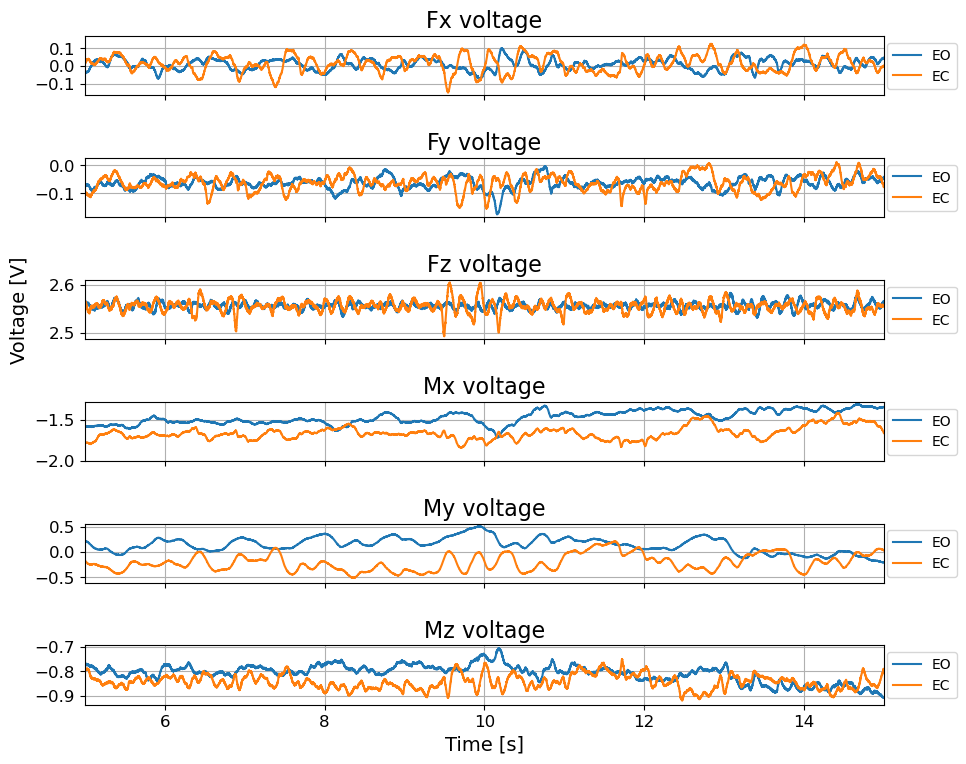

In [66]:
# Plotting function
def plot_voltage_data(df_EO, df_EC, time_range=(15, 30), figsize=(10, 8), dpi=100, pad=2.0):
    """
    Plot voltage data from two dataframes (EO and EC) over a specified time range.

    This function generates six subplots corresponding to force (Fx, Fy, Fz) and moment (Mx, My, Mz) voltage signals, comparing data from two different conditions (EO and EC).

    Args:
        df_EO (DataFrame): Data containing EO (Eyes Open) condition, with columns 'Time', 'VFx', 'VFy', 'VFz', 'VMx', 'VMy', 'VMz'.
        df_EC (DataFrame): Data containing EC (Eyes Closed) condition, with the same columns as `df_EO`.
        time_range (tuple, optional): The time range (start, end) in seconds for plotting. Defaults to (15, 30).
        figsize (tuple, optional): The figure size as (width, height). Defaults to (10, 8).
        dpi (int, optional): Dots per inch (DPI) setting for the figure resolution. Defaults to 100.
        pad (float, optional): Padding for `tight_layout` to adjust subplot spacing. Defaults to 2.0.

    Raises:
        ValueError: If the input dataframes do not contain the required voltage columns.

    Example:
        >>> plot_voltage_data(df_EO, df_EC, time_range=(10, 25))
    """
    # Create subplots
    fig, axs = plt.subplots(6, 1, sharex=True, sharey=False, dpi=dpi, figsize=figsize)

    # Plot data for each subplot
    for i, (col, title) in enumerate(zip(['VFx', 'VFy', 'VFz', 'VMx', 'VMy', 'VMz'],
                                         ['Fx voltage', 'Fy voltage', 'Fz voltage', 'Mx voltage', 'My voltage', 'Mz voltage'])):
        axs[i].plot(df_EO['Time'], df_EO[col], color='tab:blue', alpha=1.0, label='EO')
        axs[i].plot(df_EC['Time'], df_EC[col], color='tab:orange', alpha=1.0, label='EC')
        axs[i].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
        axs[i].set_title(title)

    # Set x-axis label and limits
    plt.xlabel('Time [s]')
    plt.xlim(time_range)

    # Set y-axis label for the middle subplot
    axs[2].set_ylabel('Voltage [V]')
    fig.align_ylabels()

    # Adjust layout
    plt.tight_layout(pad=pad)

    # Show the plot
    plt.show()

# Here we will only plot between time t=5s and t=15s
plot_voltage_data(df_EO, df_EC, time_range=(5, 15), figsize=(10, 8), dpi=100, pad=2.0)

### Spectral analysis helper — interpretation and practical use

This helper uses Welch's method to compute a power spectral density (PSD) and finds a cutoff frequency where the cumulative power exceeds a chosen percentage (e.g., 95–99%). Use it to pick data‑driven low‑pass cutoffs.

Key points:
- Low-frequency peaks often correspond to physiologically meaningful sway; high-frequency broadband tails are usually noise.
- Choosing a cumulative power threshold keeps most signal energy while excluding high-frequency noise — common thresholds are 95%–99%.
- For short signals, PSD estimates can be noisy; increase segment length (if available) to improve resolution.

Diagnostics (use `plot=True`):
- Check the PSD (semilogy) for dominant components and the cumulative power curve for a clear knee where energy levels off.
- Inspect the vertical line indicating the selected cutoff — it should follow main low-frequency peaks but precede broadband noise.

Takeaway: prefer a visually justified, data-driven cutoff rather than an arbitrary frequency; the helper provides both the numeric cutoff and diagnostic plots to justify it.

In [75]:
# This a helper function for determining cutoff frequencies using cumulative power spectrum thresholding
def spectral_analysis(
    data: Union[np.ndarray, pd.Series, pd.DataFrame, Sequence[float]],
    sampling_freq: float,
    nperseg: Optional[int] = None,
    window: str = "hann",
    threshold: float = 99,
    plot: bool = False,
) -> float:
    """Estimate a cutoff frequency from the power spectral density of a 1-D signal.

    The function computes a Welch PSD and finds the frequency at which the
    cumulative power (from low to high frequency) exceeds ``threshold`` percent
    of the total power.

    Parameters
    ----------
    data:
        1-D signal to analyze. Accepts a NumPy array, pandas Series or a 1-column
        DataFrame. Passing a multi-column DataFrame will raise ``ValueError``.
    sampling_freq:
        Sampling frequency of the signal in Hz.
    nperseg:
        Length of each segment used by Welch's method. If ``None`` defaults to
        the signal length. Larger values give better frequency resolution but
        fewer averages.
    window:
        Window name passed to ``scipy.signal.welch`` (default: ``'hann'``).
    threshold:
        Percentage (0-100) of cumulative power to use as the cutoff. Default is
        99 (i.e. when 99% of the power is reached).
    plot:
        If True, display diagnostic plots using matplotlib. Specifically,
        ``spectral_analysis`` shows two stacked subplots: the PSD (semilogy)
        and the cumulative power (%) with a vertical dashed line at the
        detected cutoff frequency. The function also logs the frequency
                vector shape and the selected cutoff index at DEBUG level when
                plotting. Note that matplotlib must be available and a suitable
                display/backend present for figures to appear.

        Notes on threshold
        ------------------
        - ``threshold`` must be within (0, 100]. Passing values outside this
            range raises ``ValueError``. ``threshold`` is interpreted as a
            percentage of cumulative power (0-100).

    Returns
    -------
    float
        The cutoff frequency in Hz where the cumulative power first exceeds
        ``threshold``. If the threshold is never exceeded (e.g., threshold > 100
        or numerical issues), the function returns the lowest frequency ``f[0]``.

    Raises
    ------
    ValueError
        If ``data`` is empty, if ``sampling_freq`` is not positive, or if a
        multi-column DataFrame is provided.

    Notes
    -----
    - The function does not currently handle NaNs; callers should pre-process
      the signal (interpolate or drop) before calling.
    - The return type is a Python float (converted from NumPy types when
      necessary).

    Examples
    --------
    >>> import numpy as np
    >>> t = np.linspace(0, 1.0, 1000, endpoint=False)
    >>> x = np.sin(2*np.pi*5*t)
    >>> spectral_analysis(x, sampling_freq=1000, threshold=90)
    5.0
    """

    # Validate threshold
    if not (0 < float(threshold) <= 100):
        raise ValueError("threshold must be between 0 (exclusive) and 100 (inclusive)")

    # Convert input to 1D numpy array
    if isinstance(data, pd.DataFrame):
        if data.shape[1] == 1:
            data = data.iloc[:, 0]
        else:
            raise ValueError(
                "spectral_analysis expects a 1D signal, not a multi-column DataFrame.")
    if isinstance(data, pd.Series):
        data = data.values
    elif isinstance(data, list):
        data = np.array(data)

    if len(data) == 0:
        raise ValueError("Input data is empty")

    if sampling_freq <= 0:
        raise ValueError("Sampling frequency must be positive")

    if nperseg is None:
        nperseg = len(data)

    f, Pxx = welch(data, fs=sampling_freq, nperseg=nperseg, window=window)

    # Calculate cumulative power spectrum
    cumulative_power = np.cumsum(Pxx)

    # Normalize cumulative power to get a percentage
    cumulative_power_percent = cumulative_power / cumulative_power[-1] * 100

    # Find the index where the cumulative power levels off
    cutoff_index = np.argmax(
        cumulative_power_percent > threshold
    )  # Use the specified threshold

    if plot == True:
        # Plot the results
        plt.figure(figsize=(12, 6))

        # Plot Power Spectral Density
        plt.subplot(2, 1, 1)
        plt.semilogy(f, Pxx)
        plt.title('Power Spectral Density')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency (dB/Hz)')
        plt.grid(True)

        # Plot Cumulative Power Spectrum
        plt.subplot(2, 1, 2)
        plt.plot(f, cumulative_power_percent)
        plt.axvline(x=f[cutoff_index], color='r', linestyle='--',
                    label=f'Cutoff Frequency: {f[cutoff_index]:.2f} Hz')
        plt.title('Cumulative Power Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Cumulative Power (%)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    _LOGGER.debug("spectral_analysis: f.shape=%s, cutoff_index=%s", f.shape, cutoff_index)

    return f[cutoff_index]

### Filtering helper — summary and expected behavior

This helper centralizes realistic filtering choices: cutoff estimation, NaN handling, and application of a zero‑phase Butterworth filter when possible.

Main behaviors:
- Accepts lists, NumPy arrays, pandas Series/DataFrames and preserves the input shape/type on return where practical.
- NaN handling: `'raise'` (error), `'interpolate'` (linear/interpolate + edge fill), or `'fill'` (constant). Interpolate is a reasonable default for isolated missing samples.
- Cutoff selection: `custom_cutoff_frequency` forces a fixed cutoff; otherwise per‑channel cutoffs are estimated by `spectral_analysis` using a cumulative power threshold.
- `filtfilt` (zero‑phase) is preferred; for very short signals the code falls back to `lfilter` and logs a warning (this introduces phase shift).

Verification checklist after filtering:
- Plot raw vs filtered traces to ensure smoothing without removing expected low‑frequency structure.
- Confirm cutoff frequencies are below Nyquist and in a sensible range for your task (e.g., < fs/2).

What is the Nyquist frequency (brief)?
- Definition: Nyquist frequency = fs / 2, where fs is the sampling rate (Hz).  
    Example: if fs = 1000 Hz, Nyquist = 500 Hz.
- Why it matters: the Nyquist frequency is the highest frequency that can be represented without aliasing according to the Nyquist–Shannon sampling theorem. Frequencies above Nyquist will fold (alias) into lower frequencies and corrupt your signal.
- Practical implication for filtering: Never design a low‑pass cutoff >= Nyquist. In practice, clamp cutoffs safely below Nyquist (the helper uses 95% of Nyquist when necessary).

In [76]:
# This is a helper function for filtering timeseries data
def filter_timeseries_data(
    data: Union[List[float], np.ndarray, pd.DataFrame, pd.Series],
    sampling_freq: float,
    custom_cutoff_frequency: Optional[float] = None,
    threshold: float = 99,
    plot: bool = False,
    rolling_window: int = 10,
    butter_order: int = 4,
    nan_policy: str = "interpolate",
    nan_fill_value: Optional[float] = None,
) -> Union[List[float], np.ndarray, pd.DataFrame, pd.Series]:
    """Apply a low-pass Butterworth filter to time-series data.

    The function accepts lists, 1-D NumPy arrays, 2-D NumPy arrays with shape
    (n_samples, n_channels), pandas Series, or pandas DataFrame. When
    ``custom_cutoff_frequency`` is not given, a cutoff frequency is estimated
    per channel using :func:`spectral_analysis` with the provided ``threshold``.

    Parameters
    ----------
    data:
        Input time-series. Supported types:
        - ``list`` (treated as 1-D signal, returns ``list``)
        - ``np.ndarray`` (1-D or 2-D). For 2-D arrays filtering is applied to
          each column and the resulting array has the same shape.
        - ``pandas.Series`` (returns ``pandas.Series`` with the same index/name)
        - ``pandas.DataFrame`` (filters each column and returns a DataFrame
          preserving index and columns)
    sampling_freq:
        Sampling frequency in Hz.
    custom_cutoff_frequency:
        If provided, this scalar cutoff frequency (Hz) is used for all
        channels. Otherwise, the cutoff is estimated independently per channel
        using ``spectral_analysis`` and the given ``threshold``.
    threshold:
        Cumulative power percentage (0-100) used by ``spectral_analysis`` when
        estimating cutoffs.
    plot:
        If True, enables plotting inside the underlying ``spectral_analysis``
        calls and shows the PSD/cumulative plots. Plotting is only triggered
        when cutoffs are estimated automatically (i.e., ``custom_cutoff_frequency``
        is ``None``). For multi-channel inputs this may display one figure per
        channel and can be slow or produce many windows; set ``plot=False`` to
        suppress plotting.
    rolling_window:
        Integer window size used to apply a simple moving average to any
        pandas.Series inputs before filtering to reduce very short-term noise.
    butter_order:
        Integer order of the Butterworth filter. Defaults to 4 for a
        4th-order low-pass filter. Increasing the order makes the filter
        steeper but may introduce more ringing/artifacts.
    nan_policy:
        How to handle NaN values in the input data. Options:
        - ``'raise'`` (default): raise ``ValueError`` if NaNs are present.
        - ``'interpolate'``: interpolate NaNs along the time axis (linear
          interpolation). Works for arrays and pandas objects.
        - ``'fill'``: replace NaNs with ``nan_fill_value`` (must be provided).
    nan_fill_value:
        Value used to fill NaNs when ``nan_policy=='fill'``. If None and
        ``nan_policy=='fill'``, a ValueError is raised.
        Notes on filtering behavior
        --------------------------
        - The filter is designed with ``scipy.signal.butter`` using ``butter_order``
            and applied with ``filtfilt`` for zero-phase filtering when possible.
            For very short signals where ``filtfilt`` cannot be used the code falls
            back to ``lfilter`` and logs a WARNING; this introduces a phase shift
            relative to zero-phase filtering.
        - ``butter_order`` is validated to be an integer >= 1.

    Returns
    -------
    list | np.ndarray | pandas.Series | pandas.DataFrame
        Filtered data with the same type and shape as the input. For numpy
        arrays, columns are treated along axis=1 (i.e., shape (n_samples,
        n_channels)).

    Raises
    ------
    ValueError
        If ``data`` is not one of the supported types.

    Notes
    -----
        - The filter is a Butterworth low-pass filter implemented via
            ``scipy.signal.butter`` and applied with ``filtfilt`` for zero-phase
            filtering. The default order is 4 (4th-order) but this can be changed
            using the ``butter_order`` parameter.
        - If the estimated or provided cutoff is >= Nyquist (fs/2) it is clamped
            to 95% of Nyquist. If it is <= 0 it is clamped to 5% of Nyquist. These
            behaviours are intentional to avoid invalid filter designs.
            - NaN handling: use the ``nan_policy`` parameter to control behavior.
                Options are ``'raise'`` (default), ``'interpolate'``, or ``'fill'``.
                When ``'fill'`` is selected, ``nan_fill_value`` must be provided.
        - Estimating cutoffs via spectral analysis for many channels may be slow;
            provide ``custom_cutoff_frequency`` when possible for performance.

    Examples
    --------
    Filter a 1-D numpy signal:

    >>> filtered = filter_timeseries_data(np.array(x), sampling_freq=1000)

    Filter a pandas DataFrame (each column filtered independently):

    >>> filtered_df = filter_timeseries_data(df, sampling_freq=200)

    """
    # Accept list, ndarray, DataFrame, Series
    input_type = None
    if isinstance(data, list):
        # Convert list to numpy array
        data = np.array(data)
        input_type = 'list'
    elif isinstance(data, np.ndarray):
        input_type = 'ndarray'
    elif isinstance(data, pd.DataFrame):
        input_type = 'dataframe'
    elif isinstance(data, pd.Series):
        input_type = 'series'
    else:
        raise ValueError(
            "Unsupported data type. Please provide a list, NumPy array, pandas DataFrame, or pandas Series.")

    fs = float(sampling_freq)
    # Validate butter_order
    if not isinstance(butter_order, int) or butter_order < 1:
        raise ValueError("butter_order must be an integer >= 1")

    # Validate nan handling policy
    if nan_policy not in ("raise", "interpolate", "fill"):
        raise ValueError("nan_policy must be one of 'raise', 'interpolate', or 'fill'")

    # Handle NaNs according to policy. For pandas objects use pandas methods;
    # for numpy arrays use interpolation via numpy where appropriate.
    if input_type in ("dataframe", "series"):
        if nan_policy == "raise":
            if (isinstance(data, pd.DataFrame) and data.isna().values.any()) or (
                isinstance(data, pd.Series) and data.isna().any()
            ):
                _LOGGER.debug("NaNs detected in pandas input and nan_policy='raise' -> raising ValueError")
                raise ValueError("NaN values found in input; set nan_policy to 'interpolate' or 'fill' to handle them")
        elif nan_policy == "interpolate":
            # Linear interpolation along the index (time axis)
            if isinstance(data, pd.DataFrame):
                data = data.interpolate(axis=0).ffill().bfill()
                _LOGGER.debug("Interpolated NaNs in pandas DataFrame input (axis=0) and applied ffill/bfill for edges")
                _LOGGER.info("Interpolated NaNs in pandas DataFrame input (nan_policy='interpolate')")
            else:
                data = data.interpolate().ffill().bfill()
                _LOGGER.debug("Interpolated NaNs in pandas Series input and applied ffill/bfill for edges")
                _LOGGER.info("Interpolated NaNs in pandas Series input (nan_policy='interpolate')")
        else:  # fill
            if nan_fill_value is None:
                _LOGGER.debug("nan_policy='fill' but nan_fill_value is None -> raising ValueError")
                raise ValueError("nan_fill_value must be provided when nan_policy=='fill'")
            data = data.fillna(nan_fill_value)
            _LOGGER.debug("Filled NaNs in pandas input with value=%s", nan_fill_value)
            _LOGGER.info("Filled NaNs in pandas input with value=%s (nan_policy='fill')", nan_fill_value)
    elif input_type in ("ndarray", "list"):
        arr = np.asarray(data, dtype=float)
        if arr.ndim == 1:
            if np.isnan(arr).any():
                if nan_policy == "raise":
                    _LOGGER.debug("NaNs detected in 1D ndarray and nan_policy='raise' -> raising ValueError")
                    raise ValueError("NaN values found in input array; set nan_policy to 'interpolate' or 'fill' to handle them")
                elif nan_policy == "interpolate":
                    idx = np.arange(arr.size)
                    mask = np.isfinite(arr)
                    if not mask.all():
                        arr = np.interp(idx, idx[mask], arr[mask])
                        _LOGGER.debug("Interpolated NaNs in 1D ndarray input using numpy.interp")
                        _LOGGER.info("Interpolated NaNs in 1D ndarray input (nan_policy='interpolate')")
                else:  # fill
                    if nan_fill_value is None:
                        _LOGGER.debug("nan_policy='fill' but nan_fill_value is None -> raising ValueError")
                        raise ValueError("nan_fill_value must be provided when nan_policy=='fill'")
                    arr = np.where(np.isnan(arr), nan_fill_value, arr)
                    _LOGGER.debug("Filled NaNs in 1D ndarray input with value=%s", nan_fill_value)
                    _LOGGER.info("Filled NaNs in 1D ndarray input with value=%s (nan_policy='fill')", nan_fill_value)
            data = arr
        else:
            # 2D array: process each column
            if np.isnan(arr).any():
                if nan_policy == "raise":
                    _LOGGER.debug("NaNs detected in 2D ndarray and nan_policy='raise' -> raising ValueError")
                    raise ValueError("NaN values found in input array; set nan_policy to 'interpolate' or 'fill' to handle them")
                elif nan_policy == "interpolate":
                    arr2 = arr.copy()
                    for i in range(arr2.shape[1]):
                        col = arr2[:, i]
                        idx = np.arange(col.size)
                        mask = np.isfinite(col)
                        if not mask.all():
                            arr2[:, i] = np.interp(idx, idx[mask], col[mask])
                    data = arr2
                    n_nans = int(np.isnan(arr).sum())
                    _LOGGER.debug("Interpolated NaNs in 2D ndarray input for %d columns", arr2.shape[1])
                    _LOGGER.info("Interpolated %d NaNs in 2D ndarray input across %d columns (nan_policy='interpolate')", n_nans, arr2.shape[1])
                else:
                    if nan_fill_value is None:
                        _LOGGER.debug("nan_policy='fill' but nan_fill_value is None -> raising ValueError")
                        raise ValueError("nan_fill_value must be provided when nan_policy=='fill'")
                    data = np.where(np.isnan(arr), nan_fill_value, arr)
                    _LOGGER.debug("Filled NaNs in 2D ndarray input with value=%s", nan_fill_value)
                    n_nans = int(np.isnan(arr).sum())
                    _LOGGER.info("Filled %d NaNs in 2D ndarray input with value=%s (nan_policy='fill')", n_nans, nan_fill_value)

    def apply_filter(column, cutoff_frequency):
        # Ensure cutoff_frequency is within (0, fs/2)
        nyquist = fs / 2.0
        if cutoff_frequency >= nyquist:
            # Set to 95% of Nyquist if above or equal
            cutoff_frequency = nyquist * 0.95
        if cutoff_frequency <= 0:
            # Set to a small positive value if non-positive
            cutoff_frequency = nyquist * 0.05
        # Design Butterworth filter with configurable order
        b, a = butter(N=butter_order, Wn=cutoff_frequency,
                      btype="low", fs=fs, output="ba")

        # Smooth very short-term noise for pandas Series inputs
        if isinstance(column, pd.Series):
            column = column.rolling(window=rolling_window, min_periods=1).mean()

        # Work on numpy array copy for length/pad checks
        col_arr = np.asarray(column, dtype=float)

        # filtfilt requires length > padlen where padlen = 3*(max(len(a), len(b)) - 1)
        padlen = 3 * (max(len(a), len(b)) - 1)
        if col_arr.size <= padlen:
            # Fallback to lfilter with a warning (introduces phase shift)
            _LOGGER.warning(
                "Signal length %d <= padlen %d for filtfilt (order=%d). Falling back to lfilter which introduces phase shift.",
                col_arr.size,
                padlen,
                butter_order,
            )
            return lfilter(b, a, col_arr)

        # Zero-phase filtering
        return filtfilt(b, a, col_arr)

    if custom_cutoff_frequency is not None:
        cutoff_frequency = custom_cutoff_frequency

    if input_type == 'ndarray':
        if custom_cutoff_frequency is None:
            _LOGGER.info("Automatic cutoff estimation for %d channels (threshold=%s%%)", data.shape[1], threshold)
            cutoff_frequencies = [float(spectral_analysis(
                data=column, sampling_freq=sampling_freq, threshold=threshold, plot=plot)) for column in data.T]
        else:
            cutoff_frequencies = [cutoff_frequency] * data.shape[1]

        filtered_data = np.array([apply_filter(column, cf)
                                 for column, cf in zip(data.T, cutoff_frequencies)]).T
        try:
            cutoffs = np.asarray(cutoff_frequencies, dtype=float)
            _LOGGER.info(
                "Filtering complete for %d channels (butter_order=%d). Cutoff summary: min=%.3gHz median=%.3gHz max=%.3gHz",
                cutoffs.size,
                butter_order,
                np.nanmin(cutoffs),
                np.nanmedian(cutoffs),
                np.nanmax(cutoffs),
            )
        except Exception:
            _LOGGER.info("Filtering complete (ndarray input).")
        return filtered_data

    elif input_type == 'dataframe':
        if custom_cutoff_frequency is None:
            _LOGGER.info("Automatic cutoff estimation for %d channels (threshold=%s%%)", len(data.columns), threshold)
            cutoff_frequencies = {column: float(spectral_analysis(
                data=data[column], sampling_freq=sampling_freq, threshold=threshold, plot=plot)) for column in data.columns}
        else:
            cutoff_frequencies = {
                column: cutoff_frequency for column in data.columns}

        filtered_data = data.apply(lambda column: apply_filter(
            column, cutoff_frequencies[column.name]))
        try:
            cutoffs = np.asarray(list(cutoff_frequencies.values()), dtype=float)
            _LOGGER.info(
                "Filtering complete for %d channels (butter_order=%d). Cutoff summary: min=%.3gHz median=%.3gHz max=%.3gHz",
                cutoffs.size,
                butter_order,
                np.nanmin(cutoffs),
                np.nanmedian(cutoffs),
                np.nanmax(cutoffs),
            )
        except Exception:
            _LOGGER.info("Filtering complete (DataFrame input).")
        return filtered_data

    elif input_type == 'series':
        if custom_cutoff_frequency is None:
            cutoff_frequency = float(spectral_analysis(
                data=data, sampling_freq=sampling_freq, threshold=threshold, plot=plot))
        filtered_data = apply_filter(data, cutoff_frequency)
        _LOGGER.info("Filtering complete for 1 channel (butter_order=%d). Cutoff=%.3g Hz", butter_order, cutoff_frequency)
        return pd.Series(filtered_data, index=data.index, name=data.name)

    elif input_type == 'list':
        # Treat as 1D array
        if custom_cutoff_frequency is None:
            cutoff_frequency = float(spectral_analysis(
                data=data, sampling_freq=sampling_freq, threshold=threshold, plot=plot))
        filtered_data = apply_filter(pd.Series(data), cutoff_frequency)
        _LOGGER.info("Filtering complete for 1 channel (butter_order=%d). Cutoff=%.3g Hz", butter_order, cutoff_frequency)
        return filtered_data.tolist()

### Synthetic signal demo — what to look for

This cell creates a noisy sine wave and demonstrates the effect of different low-pass cutoffs. 

Learning points:
- How lowpass filtering progressively removes higher frequency content as the cutoff decreases.
- What over‑smoothing looks like (important features removed) vs under‑filtering (noise remains).
- The importance of choosing a cutoff relative to the signal's content (here a 20 Hz sine wave).

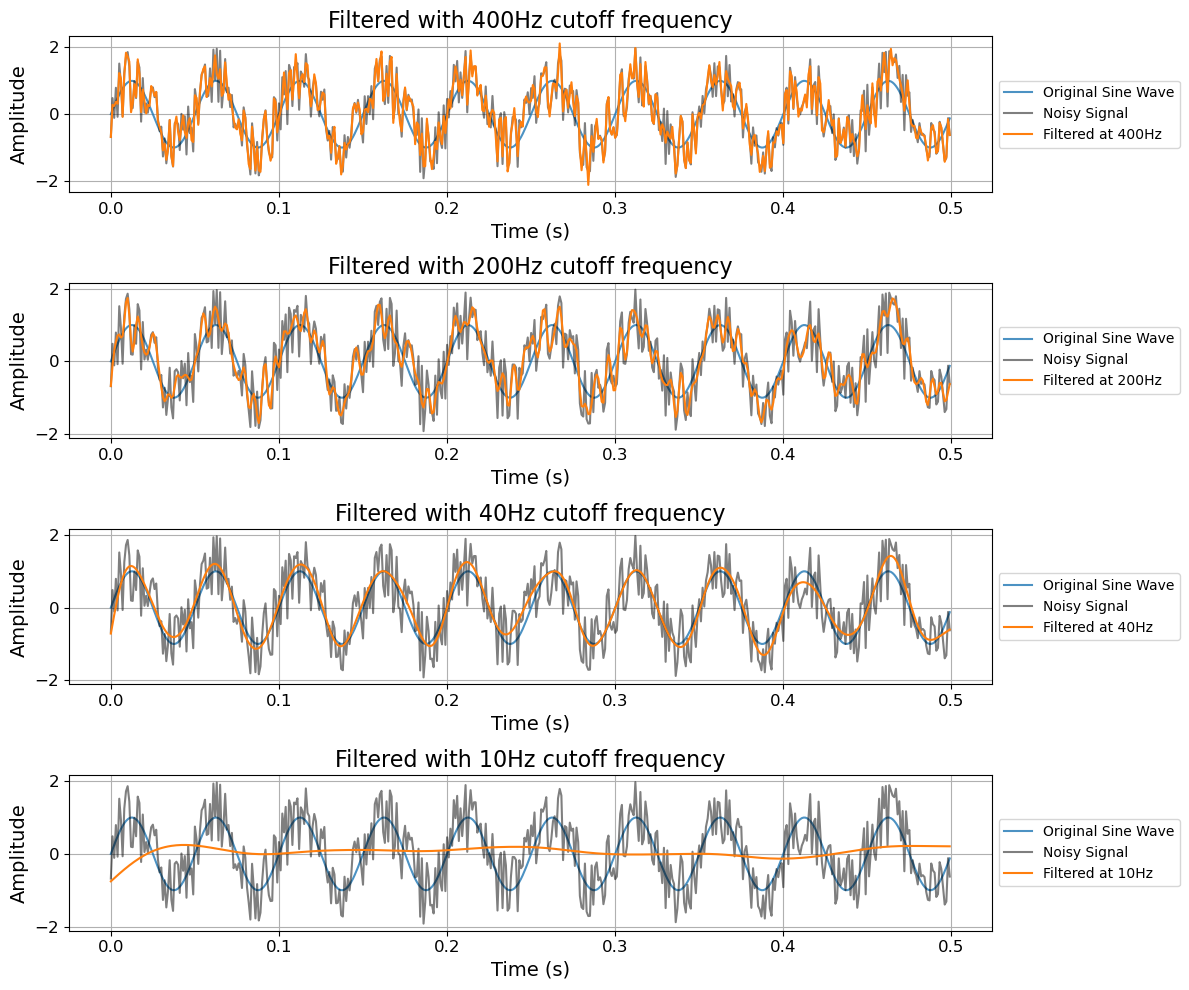

In [77]:
# Define the original signal parameters
sampling_rate = 1000  # Hz
duration = 0.5  # seconds
frequency = 20  # Hz
amplitude = 1.0  # Amplitude of the sine wave
noise_level = 1.0  # Amplitude of the noise

# Generate time vector
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Create sine wave
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# Generate noise
noise = noise_level*np.random.uniform(min(sine_wave), max(sine_wave), len(time))

# Add noise to sine wave
noisy_signal = sine_wave + noise
# Define cutoff frequencies to demonstrate aliasing
cutoff_frequencies = [400, 200, 40, 10]  # Hz, progressively lower

plt.figure(figsize=(12, 10))

def lowpass_filter(data, cutoff_freq, sampling_rate, order=4):
    """Applies a low-pass Butterworth filter to the input data."""
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(N=4, Wn=cutoff_freq,
                      btype="low", fs=sampling_rate, output="ba")
    return filtfilt(b, a, data)

for i, fc in enumerate(cutoff_frequencies, 1):
    filtered_signal = lowpass_filter(noisy_signal, fc, sampling_rate)
    # Plot results
    plt.subplot(len(cutoff_frequencies), 1, i)
    plt.plot(time, sine_wave, color='tab:blue', linestyle='-', alpha=0.8, label="Original Sine Wave")
    plt.plot(time, noisy_signal, color='k', linestyle='-', alpha=0.5, label="Noisy Signal")
    plt.plot(time, filtered_signal, color='tab:orange', linestyle='-', alpha=1.0, label=f"Filtered at {fc}Hz",)

    # Position legend to the right
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Filtered with {fc}Hz cutoff frequency")

plt.tight_layout()
plt.show()

### Interactive slider — how to use and what to observe

This widget allows you to pick a manual cutoff frequency and immediately see its impact on the filtered voltage signals.

Learning points:
- Observe how the traces become smoother as cutoff decreases and how details are lost when the cutoff is set too low.
- Note the update time: filtering multiple channels may take a few seconds after moving the slider.
- Use this tool to develop an intuition for a reasonable range of cutoff frequencies before using data-driven spectral methods.

In [78]:
# Use the slider to see how using different cutoff frequencies effects the signal
cutoff_freq = ipywidgets.widgets.FloatSlider(value=25, min=0.1, max=49.9, step=0.1, description='Cutoff Frequency (Hz):')

def filter_and_plot(cutoff_freq):
  filtered_data_EO = filter_timeseries_data(df_EO, 100, custom_cutoff_frequency=cutoff_freq, plot=False)
  filtered_data_EC = filter_timeseries_data(df_EC, 100, custom_cutoff_frequency=cutoff_freq, plot=False)

  plot_voltage_data(filtered_data_EO, filtered_data_EC, time_range=(5, 15), figsize=(10, 8), dpi=100, pad=2.0)

out = ipywidgets.interactive_output(filter_and_plot, {'cutoff_freq': cutoff_freq})
print("Note: it may take a minute for the plot to update after moving the slider")
display(cutoff_freq, out)

Note: it may take a minute for the plot to update after moving the slider


FloatSlider(value=25.0, description='Cutoff Frequency (Hz):', max=49.9, min=0.1)

Output()

### Choosing a cumulative power threshold

To derive a data‑driven low‑pass cutoff, we find the frequency where the PSD cumulative power reaches a chosen percentage of total power (typical: 95–99%). This balances keeping sway-related energy and rejecting high‑frequency noise.

Rules of thumb
- 95% is a practical starting point for many signals; 99% is more conservative (keeps more high‑frequency content).
- Avoid extreme values: too low (e.g., <90%) can remove meaningful data; attempting to use 100% can include noise and numerical edge cases.

Diagnostics
- Always inspect the PSD and the cumulative power plot together. The chosen cutoff should fall after the dominant low‑frequency peaks but before the broadband noise floor grows.
- If the cumulative curve has no clear knee, compare several representative channels and pick a conservative compromise or use manual inspection.

Practical steps
1. Try 95% and visually inspect filtered traces versus raw traces.
2. If excessive smoothing occurs, raise toward 97–99% and re-evaluate.

Interactive use
- The threshold slider in the notebook lets you explore how thresholds change the estimated cutoff and filtered results; use the PSD diagnostics (`plot=True`) to justify your selection.

Takeaway: pick a threshold grounded in both the quantitative cumulative-power metric and the visual appearance of filtered traces — document the exact threshold in your analysis.

In [79]:
def filter_and_plot(threshold):
    # Filter the EO and EC data using the selected cutoff frequency
    df_EC_filtered = filter_timeseries_data(df_EC[['VFz']], 100, custom_cutoff_frequency=None, threshold=threshold, plot=True, nan_policy='interpolate')

    # Create two separate figures for EO and EC data
    figsize = (12, 6)
    time_range = (15, 30)
    time = np.linspace(0, len(df_EC_filtered)/100, len(df_EC_filtered))
    pad = 2.0

    fig_EC, axs_EC = plt.subplots(figsize=figsize)

    # Plot EO data
    col, title = ('VFz','Fz voltage')
    axs_EC.plot(time, df_EC[['VFz']], color='tab:blue', alpha=0.8, label='EO - Original')
    axs_EC.plot(time, df_EC_filtered, color='tab:orange', label='EO - Filtered')
    axs_EC.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
    axs_EC.set_title(title)
    axs_EC.set_xlim(time_range)

    # Set x-axis labels and limits
    axs_EC.set_xlabel('Time [s]')
    # Set y-axis label for the middle subplot in both figures
    axs_EC.set_ylabel('Voltage [V]')
    fig_EC.align_ylabels()
    # Adjust layout for both figures
    plt.tight_layout(pad=pad)
    # Adjust the layouts to avoid overlap with legends and titles
    plt.subplots_adjust(top=0.9)
    fig_EC.subplots_adjust(top=0.9)
    fig_EC.suptitle('Eyes Open Data')
    # Show plot
    plt.show()

# Create a slider for cutoff frequency
threshold_slider = widgets.FloatSlider(value=50, min=1, max=99.9, step=0.1, description='Power:')

# Create an interactive widget
interactive_plot = widgets.interactive_output(filter_and_plot, {'threshold': threshold_slider})

# Display the slider and the plot
print("Note: it may take a minute for the plot to update after moving the slider")
display(threshold_slider, interactive_plot), 

Note: it may take a minute for the plot to update after moving the slider


FloatSlider(value=50.0, description='Power:', max=99.9, min=1.0)

Output()

(None,)

## Convert measured voltages to forces and moments

This section shows how to convert the six measured channel voltages from the force plate into physical forces and moments. We provide the inverted sensitivity matrix (B), the amplifier gain (G), and the input voltage (V_0). The conversion is applied row-wise and vectorized in the code cells that follow.

What this section does
- Converts raw channel voltages $(V_{Fx}, V_{Fy}, V_{Fz}, V_{Mx}, V_{My}, V_{Mz})$ → forces/moments $(F_x, F_y, F_z, M_x, M_y, M_z)$ in SI units.
- Stores results as new columns in the existing dataframes for use in plotting and analysis.

Formula (applied per time-point):

$$\vec{Y} = \frac{10^6}{G V_0} \vec{V} B^T$$

Where:
- \($\vec{V}$\) is the 1×6 voltage row vector at a time point.
- \($B$\) is the inverted sensitivity matrix (6×6) shown below.
- The factor $10^6$ adjusts from volts/millivolts depending on your amplifier/device calibration (kept here to match the provided calibration constants).

Verification checks (quick ideas)
- Compare the mean of the vertical force ($F_z$) to the subject's body weight (mass × 9.81 m/s²) — they should be close on average.
- Plot raw voltages vs computed forces for one channel to confirm linear scaling.
- Check for unreasonable outliers in computed forces (e.g., extremely large or NaN values) and investigate missing/erroneous voltage samples.

Units and scaling notes
- Make sure the amplifier gain ($G$) and the input voltage ($V_0$) reflect your acquisition hardware. If your device uses millivolt outputs with a different amplifier gain, adjust the conversion factor accordingly.
- Document the units (N, N·m) and any scaling factors in your analysis record so others can reproduce your results.

Tips
- Keep the original voltage columns until you are comfortable with the conversion. The notebook already assigns new columns `Fx, Fy, Fz, Mx, My, Mz` to `df_EO` and `df_EC`.
- If units or calibration constants differ for your dataset, update $G$, $V_0$, or $B$ accordingly and re-run the conversion cell.

What's next
- After conversion, visualize the force and moment time-series and inspect their PSDs to plan appropriate cutoffs for filtering.

In [80]:
# Inverted sensitivity matrix, B
B = np.array([
    [2.9007,  0.0200, -0.0009, -0.0253, -0.0085,  0.0090],
    [-0.0067, 2.9024, -0.0520, -0.0366, -0.0149, -0.0341],
    [0.0046, -0.0229, 11.4206, -0.0055,  0.0055,  0.0026],
    [-0.0019,  0.0035, -0.0067,  1.4559, -0.0053, -0.0028],
    [0.0036,  0.0011, -0.0067,  0.0018,  1.1475, -0.0008],
    [0.0037,  0.0145, -0.0032,  0.0006,  0.0076,  0.6188]
])

G = 4000 # Gain
V_0 = 10 # Input voltage
CF = 1e6/(G*V_0) # Conversion factor

In [81]:
# Plotting function
def plot_data(df_EO, df_EC, df_cols, plot_titles, y_labels, time_range=(15, 30), figsize=(10, 8), dpi=200, pad=2.0):
    """
    Plot signals from two dataframes (EO and EC) over a specified time range.

    This function generates six subplots corresponding to force (Fx, Fy, Fz) and moment (Mx, My, Mz) signals,
    comparing data from two different conditions (EO and EC).

    Args:
        df_EO (DataFrame): Data containing EO (Eyes Open) condition.
        df_EC (DataFrame): Data containing EC (Eyes Closed) condition, with the same columns as df_EO.
        df_cols (list): List of column names to plot from the dataframes.
        plot_titles (list): List of titles for each subplot.
        y_labels (list): List of y-axis labels for each subplot.
        time_range (tuple, optional): Time range (start, end) in seconds for plotting. Defaults to (15, 30).
        figsize (tuple, optional): Figure size as (width, height). Defaults to (10, 8).
        dpi (int, optional): Dots per inch (DPI) setting for the figure resolution. Defaults to 200.
        pad (float, optional): Padding for tight_layout to adjust subplot spacing. Defaults to 2.0.

    Raises:
        ValueError: If the input dataframes do not contain the required columns.

    Example:
        >>> plot_data(df_EO, df_EC, ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz'], titles, labels, time_range=(10, 25))
    """
    # Create subplots
    fig, axs = plt.subplots(6, 1, sharex=True, sharey=False, dpi=dpi, figsize=figsize)

    # Plot data for each subplot
    for i, (col, title, y_label) in enumerate(zip(df_cols,
                                         plot_titles,y_labels)):
        axs[i].plot(df_EO['Time'], df_EO[col], color='tab:blue', alpha=1.0, label='EO')
        axs[i].plot(df_EC['Time'], df_EC[col], color='tab:orange', alpha=1.0, label='EC')
        axs[i].legend(bbox_to_anchor=(1.1, 1), loc='upper right')
        axs[i].set_ylabel(y_label)
        axs[i].set_title(title)

    # Set x-axis label and limits
    plt.xlabel('Time [s]')
    plt.xlim(time_range)

    # Adjust layout
    plt.tight_layout(pad=pad)

    # Show the plot
    plt.show()

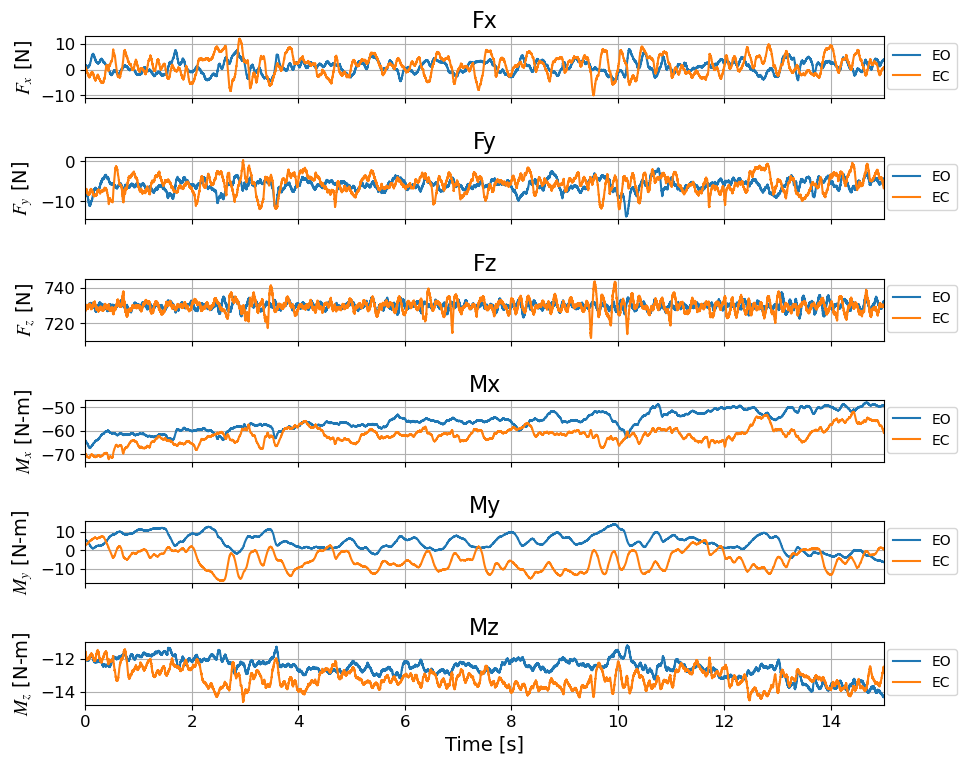

In [82]:
# Get voltages as array-like
V_EO = df_EO[['VFx', 'VFy', 'VFz', 'VMx', 'VMy', 'VMz']].to_numpy()
# Compute forces and moments in a vectorized manner
Y_EO = CF*(V_EO@B.T)
# Assign computed values back to DataFrame
df_EO[['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']] = Y_EO
# Get voltages as array-like
V_EC = df_EC[['VFx', 'VFy', 'VFz', 'VMx', 'VMy', 'VMz']].to_numpy()
# Compute forces and moments in a vectorized manner
Y_EC = CF*(V_EC@B.T)
# Assign computed values back to DataFrame
df_EC[['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']] = Y_EC

Y_cols = ['Fx','Fy','Fz','Mx','My','Mz']
plot_titles = ['Fx','Fy','Fz','Mx','My','Mz']
y_labels = ['$F_x$ [N]','$F_y$ [N]','$F_z$ [N]','$M_x$ [N-m]','$M_y$ [N-m]','$M_z$ [N-m]']

plot_data(df_EO=df_EO,df_EC=df_EC,df_cols=Y_cols,plot_titles=plot_titles,y_labels=y_labels,time_range=(0,15),dpi=100,figsize=(10,8))

## Filtering and selecting cutoff frequencies — practical guide

This section demonstrates how different low-pass cutoff choices affect moment signals and how to apply a zero-phase Butterworth filter to all force/moment channels.

What you'll see
- Example plots that compare a too-low cutoff (over‑smoothed), a too-high cutoff (insufficient noise removal), and a data-driven cutoff determined via cumulative power from the PSD.
- Code that uses `filter_timeseries_data(...)` to compute per-channel cutoffs (or accept a single custom cutoff) and perform zero‑phase filtering with `filtfilt` when possible.

How to choose cutoffs
- Too low: removes physiologically relevant sway (underestimates variability).
- Too high: keeps noise that inflates spectral/variance metrics.
- Data-driven: compute cutoff from a chosen cumulative power threshold (e.g., 95–99%). Use `spectral_analysis(..., threshold=...)` to inspect PSD/cumulative plots and select a threshold.

Recommended filtering workflow (concise)
1. Compute PSD and cumulative power for a representative segment of each channel.
2. Pick a threshold (start at 95%), compute cutoff per channel, and inspect a few filtered traces.
3. If multiple channels consistently suggest similar cutoffs, you may choose to use a common cutoff for simplicity; otherwise preserve per-channel cutoffs.
4. Apply filtering to the full dataset and save the cutoffs used alongside filtered outputs.

Common practical options
- Notch filtering: if mains interference (50/60 Hz) is present and strong, consider a narrow notch filter before low-pass filtering.
- Detrending: remove linear drift before PSD computation if low-frequency trends dominate the spectrum.
- Short recordings: filtfilt padding rules may not be satisfied; the function falls back to `lfilter` — document this and avoid phase-sensitive measures in that case.

Checking results
- Plot raw vs filtered traces and quantize differences (RMS reduction) to ensure you're not removing expected signal content.
- Compare sway metrics (range, speed) before and after filtering to understand the filter's impact.

Tip
- Save per-channel cutoff frequencies (and the threshold used to compute them) in a small JSON or CSV so your analysis is reproducible.

<class 'pandas.core.frame.DataFrame'>


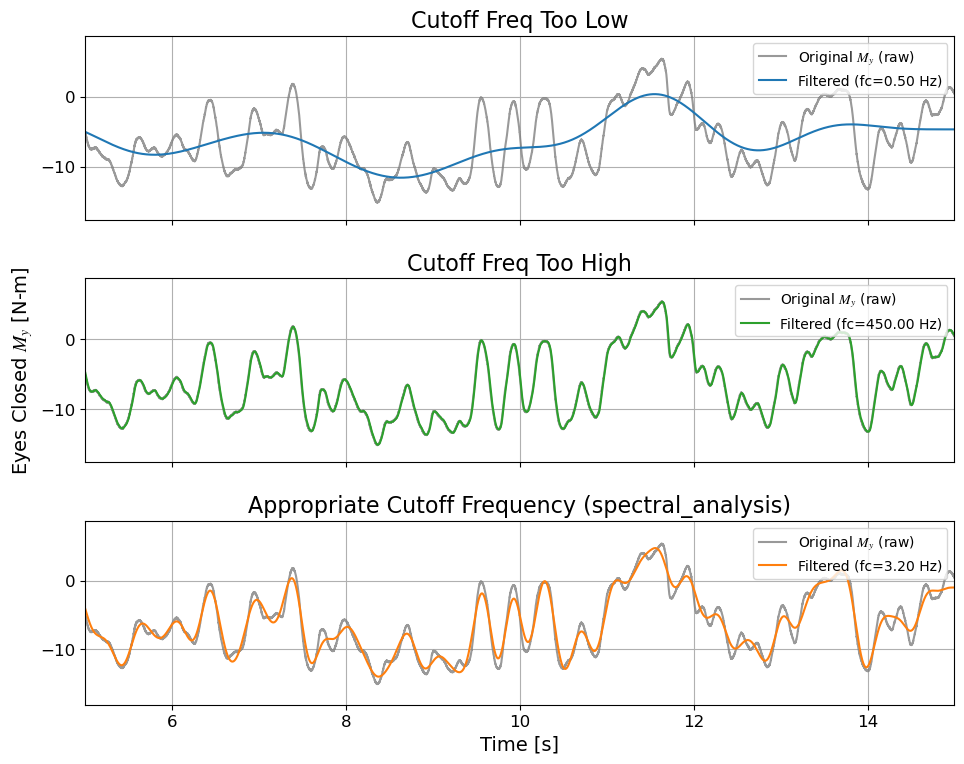

In [84]:
# Create shortened df to only include signals between 15 and 30 seconds...
f_c1_EC = 0.5 # (Hz) Too low cutoff frequency
f_c2_EC = 450 # (Hz) Too high cutoff frequency

fs = 1000 # ENSURE THAT THIS MATCHES THE DATA SAMPLING RATE!
f_c3_EC = spectral_analysis(df_EC['My'],sampling_freq=fs, threshold=95)

print(type(pd.DataFrame(df_EC['My'])))

# Filter data using too low of a cutoff frequency
df_c1 = filter_timeseries_data(pd.DataFrame(df_EC['My']),sampling_freq=fs,custom_cutoff_frequency=f_c1_EC)
# Filter data using too high of a cutoff frequency
df_c2 = filter_timeseries_data(pd.DataFrame(df_EC['My']),sampling_freq=fs,custom_cutoff_frequency=f_c2_EC)
# Filter data using an appropriate cutoff frequency
df_c3 = filter_timeseries_data(pd.DataFrame(df_EC['My']),sampling_freq=fs,custom_cutoff_frequency=f_c3_EC)

# Plot the data showing the effects of using the different cutoff frequencies
fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, dpi=100, figsize=(10, 8))

time = df_EC['Time']

# Subplot 1: too low cutoff
axs[0].plot(time, df_EC['My'], color='gray', linestyle='-', alpha=0.8, label='Original $M_y$ (raw)')
axs[0].plot(time, df_c1['My'], color='tab:blue', alpha=1.0, label=f'Filtered (fc={f_c1_EC:.2f} Hz)')
axs[0].set_title("Cutoff Freq Too Low")
axs[0].legend(loc='upper right')

# Subplot 2: too high cutoff
axs[1].plot(time, df_EC['My'], color='gray', linestyle='-', alpha=0.8, label='Original $M_y$ (raw)')
axs[1].plot(time, df_c2['My'], color='tab:green', alpha=1.0, label=f'Filtered (fc={f_c2_EC:.2f} Hz)')
axs[1].set_title("Cutoff Freq Too High")
axs[1].legend(loc='upper right')

# Subplot 3: appropriate cutoff (data-driven)
axs[2].plot(time, df_EC['My'], color='gray', linestyle='-', alpha=0.8, label='Original $M_y$ (raw)')
axs[2].plot(time, df_c3['My'], color='tab:orange', alpha=1.0, label=f'Filtered (fc={f_c3_EC:.2f} Hz)')
axs[2].set_title("Appropriate Cutoff Frequency (spectral_analysis)")
axs[2].legend(loc='upper right')

axs[-1].set_xlabel('Time [s]')
axs[1].set_ylabel('Eyes Closed $M_y$ [N-m]')

# Zoom to the 15-30 s window as intended (if available)
try:
    axs[0].set_xlim(5, 15)
except Exception:
    pass

plt.tight_layout(pad=2.0)
plt.show()

df_EO_filtered = filter_timeseries_data(df_EO, sampling_freq=fs)
df_EC_filtered = filter_timeseries_data(df_EC, sampling_freq=fs)

## Center of Pressure (CoP) — calculation and stabilogram plotting

This section explains what the Center of Pressure (CoP) is, why it matters for balance analysis, how to compute it from filtered force/moment signals, and how to visualize stabilograms for EO and EC conditions.

What is the CoP?
- The CoP is the point location on the force‑plate surface where the resultant ground reaction force acts. It is computed from vertical force and plate moments and represents the net pressure centroid under the foot/feet.
- Physically, CoP tracks how the neuromuscular system shifts load to maintain balance; it is a directly measured, high‑temporal‑resolution proxy for postural control dynamics.
- CoP is not the same as the body Center of Mass (CoM). CoM represents mass distribution of the body and typically requires motion capture and modeling; CoP is measured directly by the force plate.

Why CoP is useful
- Sensitive to corrective actions: fast corrective sways and stabilizing adjustments produce characteristic CoP excursions and velocities.
- Trial‑level and summary metrics derived from CoP (range, speed, excursion) are widely used to quantify postural stability and to compare conditions or groups (e.g., EO vs EC).
- Easy to compute and reproducible across labs when calibration and filtering are documented.

What is a stabilogram?
- A stabilogram is a 2D time‑series plot of CoP coordinates (ML vs AP) that shows the trajectory of CoP over the trial. It is the primary visualization for postural sway.
- Interpret visually:
    - Large cloud/trajectory = more sway / less stability.
    - Long, smooth excursions suggest slow drift; dense, jittery paths indicate higher-frequency corrective actions or noise.
- Complement stabilograms with scalar summaries (range, mean speed, RMS) and spectral analysis to separate slow and fast behavior.

Computation (per time point):

- Given the measured vector $\vec{Y} = (F_x, F_y, F_z, M_x, M_y, M_z)$ and the plate shear‑center offset $z_0$ (in meters), the CoP coordinates are computed as the displayed equations:

$$
\begin{aligned}
\vec{Y} &= \big(F_x,\, F_y,\, F_z,\, M_x,\, M_y,\, M_z\big) \\
x_{\mathrm{CoP}} &= \frac{M_x + z_0\,F_y}{F_z} \\[6pt]
y_{\mathrm{CoP}} &= \frac{z_0\,F_x - M_y}{F_z}
\end{aligned}
$$

- Important notes on signs and conventions: confirm that your plate calibration and sign convention match these formulas (Mx positive → generates positive x_CoP, etc.). Small sign flips in moments/forces will invert CoP axes.

Units and centering
- Keep consistent SI units: forces in N, moments in N·m, z0 in m. Convert CoP from meters to mm for plotting (multiply by 1e3) if desired for readability.
- Center stabilograms by subtracting the temporal mean from each CoP axis so the trajectory is centered at (0,0). This removes constant offsets due to subject placement.

Practical tips and pitfalls
- Handle small/zero Fz: mask, drop, or interpolate samples where Fz is near zero (division by very small values yields spurious large CoP). Consider thresholding Fz (e.g., ignore samples where Fz < some small fraction of median Fz).
- Filtering: compute CoP from filtered forces/moments (zero‑phase filtering preferred) to avoid adding high‑frequency noise in the stabilogram. Document filter design (type, order, cutoff).
- Edge effects: filtfilt requires adequate padding—short recordings may fall back to lfilter (phase shift). Avoid phase‑sensitive measures if filtfilt fallback occurs.
- Outlier checks: clip or remove sudden CoP spikes due to artifacts (e.g., transient force clipping).

Plotting guidance
- Use equal axis scales (square aspect ratio) and identical axis limits for EO and EC to allow direct visual comparison.
- Add dashed lines at zero to show anatomical midlines; annotate mean CoP and origin.
- For long traces, consider color‑coding by time, plotting a density/contour, or downsampling for clarity.
- Overlay raw vs filtered CoP (or show both on separate panels) to confirm filtering did not remove relevant low‑frequency features.

Interpretation (tandem stance example)
- Tandem stance typically increases AP sway (narrow fore‑aft base) and may increase average CoP speed; removing vision (EC) commonly further increases excursion and speed.
- Use paired comparisons (EO vs EC) and percent change together with stabilograms to report effects.

Next steps
- Compute scalar metrics from the centered CoP (AP/ML excursion ranges, mean CoP speed, mean excursion distance, std dev) and report the filter/cutoff and any sample masking thresholds used for reproducibility.
- Important notes on signs and conventions: confirm that your plate calibration and sign convention match these formulas (Mx positive → generates positive x_CoP, etc.). Small sign flips in moments/forces will invert CoP axes.

Units and centering
- Keep consistent SI units: forces in N, moments in N·m, z0 in m. Convert CoP from meters to mm for plotting (multiply by 1e3) if desired for readability.
- Center stabilograms by subtracting the temporal mean from each CoP axis so the trajectory is centered at (0,0). This removes constant offsets due to subject placement.

Practical tips and pitfalls
- Handle small/zero Fz: mask, drop, or interpolate samples where Fz is near zero (division by very small values yields spurious large CoP). Consider thresholding Fz (e.g., ignore samples where Fz < some small fraction of median Fz).
- Filtering: compute CoP from filtered forces/moments (zero‑phase filtering preferred) to avoid adding high‑frequency noise in the stabilogram. Document filter design (type, order, cutoff).
- Edge effects: filtfilt requires adequate padding—short recordings may fall back to lfilter (phase shift). Avoid phase‑sensitive measures if filtfilt fallback occurs.
- Outlier checks: clip or remove sudden CoP spikes due to artifacts (e.g., transient force clipping).

Plotting guidance
- Use equal axis scales (square aspect ratio) and identical axis limits for EO and EC to allow direct visual comparison.
- Add dashed lines at zero to show anatomical midlines; annotate mean CoP and origin.
- For long traces, consider color‑coding by time, plotting a density/contour, or downsampling for clarity.
- Overlay raw vs filtered CoP (or show both on separate panels) to confirm filtering did not remove relevant low‑frequency features.

Interpretation (tandem stance example)
- Tandem stance typically increases AP sway (narrow fore‑aft base) and may increase average CoP speed; removing vision (EC) commonly further increases excursion and speed.
- Use paired comparisons (EO vs EC) and percent change together with stabilograms to report effects.

Next steps
- Compute scalar metrics from the centered CoP (AP/ML excursion ranges, mean CoP speed, mean excursion distance, std dev) and report the filter/cutoff and any sample masking thresholds used for reproducibility.

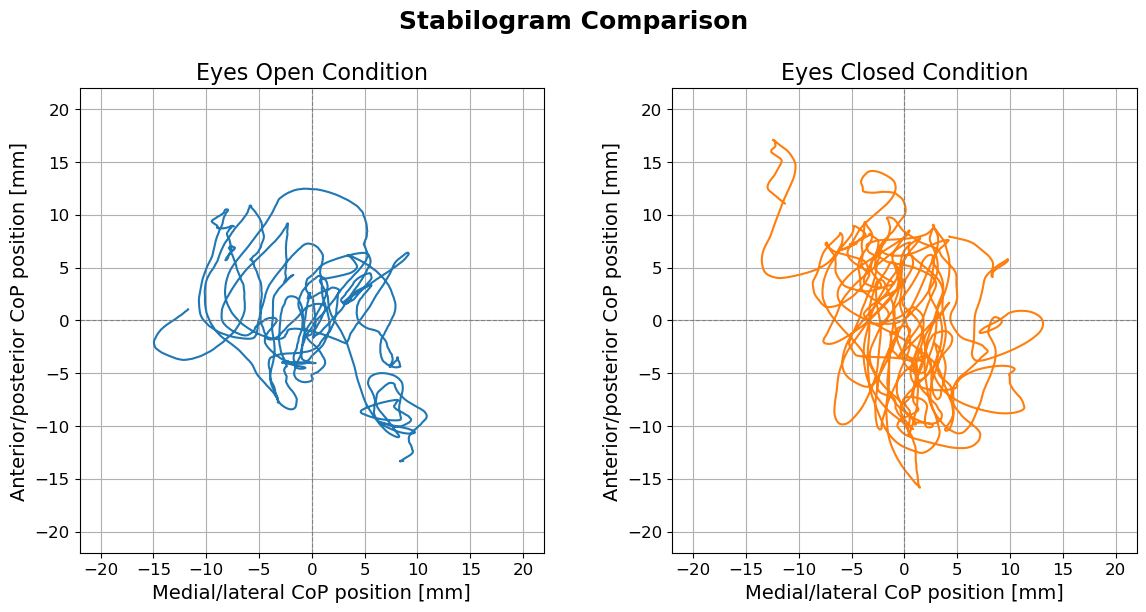

In [85]:
z_0 = -37.645*1e-3 # (m) Shear center relative to geometric center

COPx_EO = (df_EO_filtered['Mx']+z_0*df_EO_filtered['Fy'])/df_EO_filtered['Fz']
COPy_EO = (df_EO_filtered['My']-z_0*df_EO_filtered['Fx'])/df_EO_filtered['Fz']

COPx_EC = (df_EC_filtered['Mx']+z_0*df_EC_filtered['Fy'])/df_EC_filtered['Fz']
COPy_EC = (df_EC_filtered['My']-z_0*df_EC_filtered['Fx'])/df_EC_filtered['Fz']

COPx_EO_centered = (COPx_EO - COPx_EO.mean())*1e3 # Convert to mm
COPy_EO_centered = (COPy_EO - COPy_EO.mean())*1e3 # Convert to mm

COPx_EC_centered = (COPx_EC - COPx_EC.mean())*1e3 # Convert to mm
COPy_EC_centered = (COPy_EC - COPy_EC.mean())*1e3 # Convert to mm

fig, axs = plt.subplots(1, 2, dpi=100, figsize=(12,6))

# Determine the maximum range for centering around (0,0)
x_max = np.ceil(1.25*max(abs(COPx_EO_centered.min()), abs(COPx_EO_centered.max()),
            abs(COPx_EC_centered.min()), abs(COPx_EC_centered.max())))
y_max = np.ceil(1.25*max(abs(COPy_EO_centered.min()), abs(COPy_EO_centered.max()),
            abs(COPy_EC_centered.min()), abs(COPy_EC_centered.max())))

max_range = max(x_max, y_max)  # Ensure square limits

# First subplot (EO)
axs[0].plot(COPx_EO_centered, COPy_EO_centered, color='tab:blue', label='EO')
axs[0].set_xlim(-max_range, max_range)
axs[0].set_ylim(-max_range, max_range)
axs[0].set_xlabel('Medial/lateral CoP position [mm]')
axs[0].set_ylabel('Anterior/posterior CoP position [mm]')
axs[0].set_title('Eyes Open Condition')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axs[0].axvline(0, color='gray', linestyle='--', linewidth=0.8)
axs[0].set_aspect('equal')  # Ensures square aspect ratio

# Second subplot (EC)
axs[1].plot(COPx_EC_centered, COPy_EC_centered, color='tab:orange', label='EC')
axs[1].set_xlim(-max_range, max_range)
axs[1].set_ylim(-max_range, max_range)
axs[1].set_xlabel('Medial/lateral CoP position [mm]')
axs[1].set_ylabel('Anterior/posterior CoP position [mm]')
axs[1].set_title('Eyes Closed Condition')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axs[1].axvline(0, color='gray', linestyle='--', linewidth=0.8)
axs[1].set_aspect('equal')  # Ensures square aspect ratio

# Set overall figure title with large font
fig.suptitle('Stabilogram Comparison', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

## Balance metrics — definitions, computation, and interpretation

This section computes commonly used scalar summary metrics from CoP time series and explains how to interpret them in the context of balance tasks.

Metrics computed in the notebook
- AP excursion range: max(CoP_x) - min(CoP_x) (mm)
- ML excursion range: max(CoP_y) - min(CoP_y) (mm)
- Average CoP speed: mean( sqrt( (dx/dt)^2 + (dy/dt)^2 ) ) (mm/s)
- Mean excursion distance: mean( sqrt(x^2 + y^2) ) (mm)
- Std dev of excursion distance: std( sqrt(x^2 + y^2) ) (mm)

Implementation notes
- Use centered CoP (subtract temporal mean) so offsets do not inflate range measures.
- Compute derivatives using successive differences divided by dt (ensure consistent units: mm vs m).
- For average speed, ignore NaN or masked samples (e.g., where Fz was invalid). Consider thresholding small Fz values before computing CoP.
- Document sampling rate, filter design (type, order, cutoff) and any NaN handling — metrics are sensitive to filtering and preprocessing.

How to interpret each metric (practical guide)
- AP / ML excursion ranges
    - What they measure: trial-wide span of CoP in anterior–posterior and medial–lateral axes.
    - Larger values → greater gross excursion (more sway or larger shifts of load). Directional changes (AP vs ML) can indicate task-specific instability (e.g., tandem stance increases AP).
    - Caveats: ranges are sensitive to brief large transients (artifacts). Check stabilograms to confirm excursions reflect behaviour, not noise.
- Average CoP speed
    - What it measures: time-averaged instantaneous CoP velocity; captures how actively the subject is correcting posture.
    - Larger speed → more frequent/rapid corrective actions or noise. Often more sensitive to subtle balance changes than range.
    - Caveats: speed increases with trial length variability and with higher-frequency noise; ensure consistent filtering across conditions.
- Mean excursion distance
    - What it measures: average radial distance from center (magnitude of sway).
    - Larger mean distance → CoP is on average farther from center; useful summary of overall displacement.
    - Complement with range and speed to distinguish broad drift vs frequent small corrections.
- Std dev of excursion distance
    - What it measures: variability of radial CoP magnitude; indicates consistency vs intermittency of sway.
    - Larger std → more variable control (bursty corrections or inconsistent posture).

Practical interpretation rules of thumb
- Compare within-subject, within-task (paired comparisons) whenever possible; absolute values depend on posture, footwear, surface, and trial duration.
- Use percent change and paired statistics (paired t-test, Wilcoxon) for EO vs EC or pre/post designs — report effect size and confidence intervals, not only p-values.
- Visual checks: always inspect stabilograms (trajectory) and raw vs filtered traces to ensure metrics reflect behavior.
- Filtering matters: a more aggressive low-pass reduces speed and high-frequency variance while leaving gross ranges less affected. Report filter parameters.

Handling artifacts and edge cases
- Outliers: remove or clip transient spikes before computing range/speed.
- Low/zero Fz: mask samples where Fz is near zero (division instability) or interpolate short gaps.
- Short trials: filtfilt padding may fail and introduce phase shift; avoid phase-sensitive metrics if lfilter fallback occurs.

In [87]:
dt = 1/fs # Time difference between adjacent time points

# AP (Anterior-Posterior) Excursion Range
AP_EO = COPx_EO_centered.max() - COPx_EO_centered.min()
AP_EC = COPx_EC_centered.max() - COPx_EC_centered.min()

# ML (Medio-Lateral) Excursion Range
ML_EO = COPy_EO_centered.max() - COPy_EO_centered.min()
ML_EC = COPy_EC_centered.max() - COPy_EC_centered.min()

# Average CoP Speed
Avg_CoP_Speed_EO = (np.sqrt(COPx_EO_centered.diff()**2 + COPy_EO_centered.diff()**2)/dt).mean()
Avg_CoP_Speed_EC = (np.sqrt(COPx_EC_centered.diff()**2 + COPy_EC_centered.diff()**2)/dt).mean()

# Mean Excursion Distance
Mean_Excursion_Distance_EO = np.sqrt(COPx_EO_centered**2 + COPy_EO_centered**2).mean()
Mean_Excursion_Distance_EC = np.sqrt(COPx_EC_centered**2 + COPy_EC_centered**2).mean()

# Standard Deviation of Excursion Distance
StDev_Excursion_Distance_EO = np.sqrt(COPx_EO_centered**2 + COPy_EO_centered**2).std()
StDev_Excursion_Distance_EC = np.sqrt(COPx_EC_centered**2 + COPy_EC_centered**2).std()

# Print the calculated metrics
print("Eyes Open Condition:")
print("AP Excursion Range: {:.2f} mm".format(AP_EO))
print("ML Excursion Range: {:.2f} mm".format(ML_EO))
print("Average CoP Speed: {:.2f} mm/s".format(Avg_CoP_Speed_EO))
print("Mean Excursion Distance: {:.2f} mm".format(Mean_Excursion_Distance_EO))
print("Standard Deviation of Excursion Distance: {:.2f} mm".format(StDev_Excursion_Distance_EO))

print("\nEyes Closed Condition:")
print("AP Excursion Range: {:.2f} mm".format(AP_EC))
print("ML Excursion Range: {:.2f} mm".format(ML_EC))
print("Average CoP Speed: {:.2f} mm/s".format(Avg_CoP_Speed_EC))
print("Mean Excursion Distance: {:.2f} mm".format(Mean_Excursion_Distance_EC))
print("Standard Deviation of Excursion Distance: {:.2f} mm".format(StDev_Excursion_Distance_EC))

# Calculate Percent change using (EC - EO) / EO * 100
AP_percent_change = (AP_EC - AP_EO) / AP_EO * 100
ML_percent_change = (ML_EC - ML_EO) / ML_EO * 100
Avg_CoP_Speed_percent_change = (Avg_CoP_Speed_EC - Avg_CoP_Speed_EO) / Avg_CoP_Speed_EO * 100
Mean_Excursion_Distance_percent_change = (Mean_Excursion_Distance_EC - Mean_Excursion_Distance_EO) / Mean_Excursion_Distance_EO * 100
StDev_Excursion_Distance_percent_change = (StDev_Excursion_Distance_EC - StDev_Excursion_Distance_EO) / StDev_Excursion_Distance_EO * 100

# Print the percent differences
print("\nPercent change from Eyes Open to Eyes Closed conditions:")

print("AP Excursion Range: {:+.2f} %".format(AP_percent_change))
print("ML Excursion Range: {:+.2f} %".format(ML_percent_change))
print("Average CoP Speed: {:+.2f} %".format(Avg_CoP_Speed_percent_change))
print("Mean Excursion Distance: {:+.2f} %".format(Mean_Excursion_Distance_percent_change))
print("Standard Deviation of Excursion Distance: {:+.2f} %".format(StDev_Excursion_Distance_percent_change))


Eyes Open Condition:
AP Excursion Range: 25.84 mm
ML Excursion Range: 25.82 mm
Average CoP Speed: 29.84 mm/s
Mean Excursion Distance: 6.92 mm
Standard Deviation of Excursion Distance: 3.72 mm

Eyes Closed Condition:
AP Excursion Range: 26.63 mm
ML Excursion Range: 32.95 mm
Average CoP Speed: 53.20 mm/s
Mean Excursion Distance: 7.36 mm
Standard Deviation of Excursion Distance: 3.70 mm

Percent change from Eyes Open to Eyes Closed conditions:
AP Excursion Range: +3.08 %
ML Excursion Range: +27.60 %
Average CoP Speed: +78.31 %
Mean Excursion Distance: +6.33 %
Standard Deviation of Excursion Distance: -0.64 %
